# Text To Image using Stable Diffusion
## Based on the [Stable Diffusion model](https://huggingface.co/CompVis/stable-diffusion-v1-4)
### Code by Justin Muller, September 2022

From [Wikipedia](https://en.wikipedia.org/wiki/Stable_Diffusion): "Stable Diffusion is a machine learning, text-to-image model developed by StabilityAI, in collaboration with EleutherAI and LAION, to generate digital images from natural language descriptions. The model can be used for other tasks too, like generating image-to-image translations guided by a text prompt.  Stable Diffusion was trained on a subset of the LAION-Aesthetics V2 dataset. It was trained using 256 Nvidia A100 GPUs at a cost of $600,000."

This notebook will walk through the process of deploying the Stable Diffusion model to an AWS SageMaker endpoint.  We'll start by downloading the model locally to test it out. Next, we create a custom docker container which contains the model.  In this use case, we will have the endpoint put the generated images directly in an S3 bucket, and return the location of the image.

Note that this model is large.  You'll want to make sure to use an instance type with at least 15GB of storage in order to have space to download the model and package up the container. This notebook was tested on a ml.g4dn.2xlarge with 25GB of EBS storage, you can also run it on CPU based instances but the performance might be impacted.

While the Stable Diffusion model is free and open source, it does require agreeing to the terms and conditions on Hugging Face.  In order to download this model, you will need to create a free HuggingFace account, and then visit the [stable diffusion model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) and agree to the terms and conditions.  Once that is done, visit your [Hugging Face Access Tokens page](https://huggingface.co/settings/tokens) and create a token for use in this notebook.

The notebook follows these basic steps:
1. Install Dependencies (for local testing)
2. Test the model locally
3. Create a custom inference script
4. Create a custom Docker container for the model and inference script
4. Define and Deploy the model
5. Test the new endpoint
6. Clean up resources

References:
  * [Stable Diffusion Model on Hugging Face](https://huggingface.co/CompVis/stable-diffusion-v1-4)

Container Structure:  This should be the directory structure locally, in order to pack everything correctly into your container. ([reference](https://sagemaker-workshop.com/custom/containers.html))  You will already have this structure if you cloned the git repo, if not, following the directions in this notebook will rebuild this structure and all required files.
- This Notebook
- container
    - TTI
        - predictor.py: Flask app for inference, our custom inference code
        - wsgi.py: Wrapper around predictor
        - nginx.conf: Config for nginx front-end
        - serve: Launches gunicorn server
        - stable-diffusion-v1-4/ : This is the actual model downloaded from git.
    - Dockerfile

# 1. Install Dependencies

### 1(a) Install local python libraries
This step will install the required python libraries to run this model.  You only need to do step 1(a) if you would like to test the model locally, and have access to a GPU.  We are using PyTorch for the model, and the diffusers and transformers libraries from HuggingFace which make it easy to download and run the model.

In [1]:
!pip install --upgrade torch diffusers transformers scipy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.2/236.2 KB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 126.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 61.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 KB 40.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.1
    Uninstalling scipy-1.9.1:
      Successfully uninstalled scipy-1.9.1
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.9.1
    Uninstalling huggingface-hub-0.9.1:
      Successfully uninstalled huggingface-hub-0.9.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.22.2
    Uninstalling transformers-4.22.2:
      Successfully uninstalled transformers-4.22.2
  Attempting uninstall: diffusers
    Found existing installati

### 1(b) Install Git LFS to download model weights

HuggingFace provides an easy way to download model weights from python, but here we are going to download the weights manually ahead of time.  This allows us to package the weights inside the docker container, and eliminate an external dependency while speeding up the start up time for the endpoint.


The model weights are stored in git, but because they are so big they require Git's Large File Storage (LFS) to download.  This installation instruction assumes you are running on a SageMaker notebook instance, but if you are in another environment you can find installation instructions [here](https://git-lfs.github.com/).  


Open a terminal by going back to the Jupyter homepage, and clicking on the "New" dropdown.  Run these commands after creating a HuggingFace account and accepting the license at the main repo.  At the git clone stage, it will ask for your HuggingFace username and password, which must be an account that has accepted the Stable Diffusion terms and conditions.

Make sure you start in the same directory that this notebook is in.

    mkdir container
    
    cd container
    
    mkdir TTI
    
    cd TTI
    
    sudo yum install -y amazon-linux-extras
    
    sudo amazon-linux-extras install epel -y
    
    sudo yum-config-manager --enable epel
    
    sudo yum install git-lfs
    
    git lfs install --skip-smudge
    
    git clone https://huggingface.co/CompVis/stable-diffusion-v1-4
    
    cd stable-diffusion-v1-4/
    
    git lfs pull
    
    git lfs install --force  //to turn back on smudge
    
    #Finally, remove this repo's git information to save space, because we only want the model weights.
    
    rm -r .git
    
    rm -r .gitattributes

### 1(c) Set up SageMaker environment
This gives us access to basic information and functionality for our SageMaker environment, including the IAM role we are going to use in the next setup step.

In [2]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it does not exist
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

#used later on when deploying a model:
sm_client = boto3.client(service_name='sagemaker')
runtime_sm_client = boto3.client(service_name='sagemaker-runtime')
account_id = boto3.client('sts').get_caller_identity()['Account']
region = boto3.Session().region_name

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::616455080294:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole
sagemaker bucket: sagemaker-us-east-1-616455080294
sagemaker session region: us-east-1


### 1(d) Set up IAM permissions
In addition to the default IAM permissions, you need to add S3 access (because the model stores images in S3, and ECR access because we push our custom docker container to ECR for use by SageMaker. 

Add this policy for ECR access, note that you are giving permission to create a new repository, as well as push images to it.
`
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "ecr:CompleteLayerUpload",
                "ecr:GetAuthorizationToken",
                "ecr:UploadLayerPart",
                "ecr:InitiateLayerUpload",
                "ecr:BatchCheckLayerAvailability",
                "ecr:PutImage",
                "ecr:CreateRepository"
            ],
            "Resource": "*"
        }
    ]
}
`

For S3 access, add this policy.  *Note*:you may want to create a bucket for your images.

`
{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Action": ["s3:ListBucket"],
      "Resource": ["arn:aws:s3:::YOURBUCKETNAME"]
    },
    {
      "Effect": "Allow",
      "Action": [
        "s3:PutObject",
        "s3:GetObject",
        "s3:DeleteObject"
      ],
      "Resource": ["arn:aws:s3:::YOURBUCKETNAME/*"]
    }
  ]
}
`

# 2. Test the model locally
This allows a user to get a feel for what the model can do, and how to use the hyperparameters.  Feel free to skip this step if you are already comfortable with the model.

In [3]:
%%time
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline

#If you want to download the model using HuggingFace rather than Git:
#model_id = "CompVis/stable-diffusion-v1-4"
#HF_token = "YOURTOKENHERE"
#pipe = StableDiffusionPipeline.from_pretrained(model_id,use_auth_token=HF_token)

#this is where we downloaded the model to using Git LFS in step 1(b)
#if this directory does not exist, the model loader will think it's a URL and give you a URL not found error.
local_model_dir = "container/TTI/stable-diffusion-v1-4"

#loading the model from the locally saved weights still takes up to a minute.
pipe = StableDiffusionPipeline.from_pretrained(local_model_dir)

#move the tensors we just loaded into the GPU memory
if torch.cuda.is_available():
    pipe = pipe.to("cuda")
    
#When this option is enabled, the attention module will split the input tensor in slices, to compute attention
#in several steps. This is useful to save some memory in exchange for a small speed decrease.
pipe.enable_attention_slicing()

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


CPU times: user 15 s, sys: 6.02 s, total: 21 s
Wall time: 18.8 s


### You can use the following cell to try out a few different prompts and hyperparameters.

The default hyperparameter values are:
  * guidance_scale=7.5 On a scale from 0-10, how much should the prompt influence the result.
  * num_inference_steps=50 On a scale from 0-100, how many steps should the model take?  A higher number means a longer run time, with higher quality results.
  * height=512  This must be >512 and a multiple of 8.  Either height or width should be 512
  * width=512  This must be >512 and a multiple of 8.  Either height or width should be 512
  * results=1 This isn't really a hyperparameter, but it tells the algorithm how many alternative images you would like to see using the same prompt.


  0%|          | 0/51 [00:00<?, ?it/s]

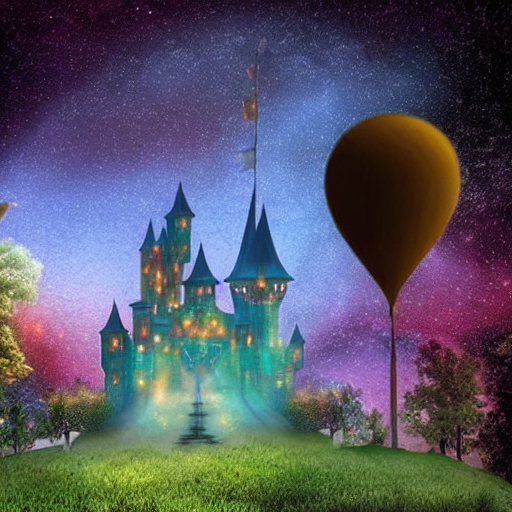

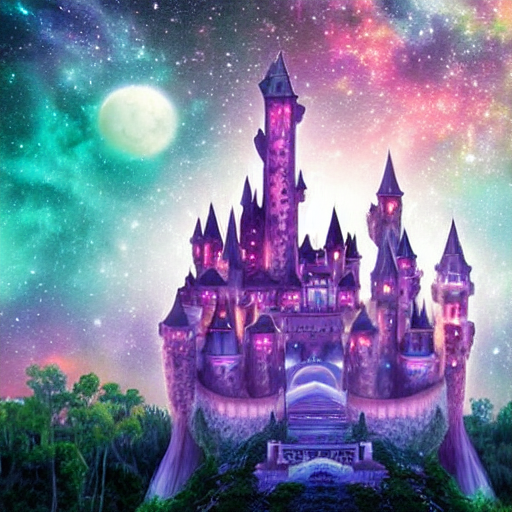

CPU times: user 25.4 s, sys: 4.16 s, total: 29.6 s
Wall time: 29.4 s


In [9]:
%%time
prompt = "a dream castle, overlooking the universe, ethereal colors"
results = 2
with autocast("cuda"):
    images = pipe([prompt]*results, guidance_scale=7.5,num_inference_steps=50,height=512,width=512)["sample"]
for image in images:
    display(image)

# 3. Create the custom inference script
This is the script that will run the inference.  It is packaged in a Flask web service to unload the request, and pack up the response.  Note that you can add your own bucket name and folder in that bucket, for where you want the endpoint to deposit the generated images.

In [27]:
%%writefile container/TTI/predictor.py
from flask import Flask
import flask
import os
import json
import logging

import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
import io
import uuid
import boto3

#the model is packaged directly into the container, and is found in this directory just like when we ran locally.
local_model_dir = "./stable-diffusion-v1-4"

#Replace this bucket and folder name with your own location for the images to be delivered to.
BUCKET_NAME = "YOUR BUCKET NAME HERE"
FOLDER = "YOUR FOLDER NAME HERE/"

#Load model from our local weights
pipe = StableDiffusionPipeline.from_pretrained(local_model_dir)
#move the vectors to the GPU, if avaliable.
if torch.cuda.is_available():
    pipe = pipe.to("cuda")

# The flask app for serving predictions
app = Flask(__name__)
@app.route('/ping', methods=['GET'])
def ping():
    # Check if the classifier was loaded correctly
    # Sagemaker will ping this regularly to check that the endpoint is healthy.
    health = pipe is not None# pipe was loaded
    status = 200 if health else 404
    return flask.Response(response= '\n', status=status, mimetype='application/json')


@app.route('/invocations', methods=['POST'])
def transformation():
    
    # Grab the prompt from the HTTP request
    input_json = flask.request.get_json()
    
    #Grab the prompt from the input_json, if any.
    if "prompt" in input_json:
        prompt = input_json['prompt']
    else:
        prompt = ""
    print ("New request:"+prompt)
    
    #Grab the hyperparmeters from the input_json, if any.
    if "guidance_scale" in input_json:
        guidance_scale = input_json['guidance_scale']
    else:
        guidance_scale = 7.5
        
    if "num_inference_steps" in input_json:
        num_inference_steps = input_json['num_inference_steps']
    else:
        num_inference_steps = 50
        
    if "height" in input_json:
        height = input_json['height']
    else:
        height = 512
        
    if "width" in input_json:
        width = input_json['width']
    else:
        width = 512
        
    if "results" in input_json:
        results = input_json['results']
    else:
        results = 1
        
    
    #create a random name to use for the image to be generated.
    image_names = []        
    try:
        #Compute image from prompt
        with autocast("cuda"):
            images = pipe([prompt]*results, guidance_scale=guidance_scale,num_inference_steps=num_inference_steps,height=height,width=width)["sample"]   
        
        for image in images:
            image_name = uuid.uuid4().hex + ".png"
            #save the image to S3
            client_s3 = boto3.client('s3')
            #First, save the image to an in-memory file
            in_mem_file = io.BytesIO()
            image.save(in_mem_file, format="png")
            in_mem_file.seek(0)
            #Then, upload the in-memory file to S3
            client_s3.upload_fileobj(
                in_mem_file,
                BUCKET_NAME,
                FOLDER+image_name
            )
            image_names.append(image_name)

        #send image S3 location as result
        result = {'s3_loc': image_names}
    except Exception as e:
        #send an error message
        result = {'s3_loc': "error","error":str(e)}
        
    resultjson = json.dumps(result)
    return flask.Response(response=resultjson, status=200, mimetype='application/json')

Overwriting container/TTI/predictor.py


Now let's make a small modification to the serve file.  Normally, it would spawn a worker thread for each CPU core, but this doesn't work in our case because the process is GPU bound.  The original serve file lines are all here, but we add the model_server_workers = 1 to limit the endpoint to only loading a single model into the GPU.  Additional logic may be required if using an instance type with multiple GPU's.

In [13]:
%%writefile container/TTI/serve
#!/usr/bin/env python

# This file implements the scoring service shell. You don't necessarily need to modify it for various
# algorithms. It starts nginx and gunicorn with the correct configurations and then simply waits until
# gunicorn exits.
#
# The flask server is specified to be the app object in wsgi.py
#
# We set the following parameters:
#
# Parameter                Environment Variable              Default Value
# ---------                --------------------              -------------
# number of workers        MODEL_SERVER_WORKERS              the number of CPU cores
# timeout                  MODEL_SERVER_TIMEOUT              60 seconds

import multiprocessing
import os
import signal
import subprocess
import sys

cpu_count = multiprocessing.cpu_count()

model_server_timeout = os.environ.get('MODEL_SERVER_TIMEOUT', 60)
model_server_workers = int(os.environ.get('MODEL_SERVER_WORKERS', cpu_count))

#for our GPU based inference, set to one.  This process is GPU bound, and the GPU may run out of space if more than one model is loaded.
model_server_workers = 1

def sigterm_handler(nginx_pid, gunicorn_pid):
    try:
        os.kill(nginx_pid, signal.SIGQUIT)
    except OSError:
        pass
    try:
        os.kill(gunicorn_pid, signal.SIGTERM)
    except OSError:
        pass

    sys.exit(0)

def start_server():
    print('Starting the inference server with {} workers.'.format(model_server_workers))


    # link the log streams to stdout/err so they will be logged to the container logs
    subprocess.check_call(['ln', '-sf', '/dev/stdout', '/var/log/nginx/access.log'])
    subprocess.check_call(['ln', '-sf', '/dev/stderr', '/var/log/nginx/error.log'])

    nginx = subprocess.Popen(['nginx', '-c', '/opt/program/nginx.conf'])
    gunicorn = subprocess.Popen(['gunicorn',
                                 '--timeout', str(model_server_timeout),
                                 '-k', 'sync',
                                 '-b', 'unix:/tmp/gunicorn.sock',
                                 '-w', str(model_server_workers),
                                 'wsgi:app'])

    signal.signal(signal.SIGTERM, lambda a, b: sigterm_handler(nginx.pid, gunicorn.pid))

    # If either subprocess exits, so do we.
    pids = set([nginx.pid, gunicorn.pid])
    while True:
        pid, _ = os.wait()
        if pid in pids:
            break

    sigterm_handler(nginx.pid, gunicorn.pid)
    print('Inference server exiting')

# The main routine just invokes the start function.

if __name__ == '__main__':
    start_server()


Overwriting container/TTI/serve


Next, we write an nginx configuration file.  This is standard for most custom containers, and we don't make any changes for this model.

In [14]:
%%writefile container/TTI/nginx.conf
worker_processes 1;
daemon off; # Prevent forking


pid /tmp/nginx.pid;
error_log /var/log/nginx/error.log;

events {
  # defaults
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /var/log/nginx/access.log combined;
  
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 5m;

    keepalive_timeout 5;
    proxy_read_timeout 1200s;

    location ~ ^/(ping|invocations) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_pass http://gunicorn;
    }

    location / {
      return 404 "{}";
    }
  }
}

Overwriting container/TTI/nginx.conf


Finally, we write a quick wrapper for wsgi, so that the web server can find and load our inference script.

In [15]:
%%writefile container/TTI/wsgi.py
import predictor as myapp

# This is just a simple wrapper for gunicorn to find your app.
# If you want to change the algorithm file, simply change "predictor" above to the
# new file.

app = myapp.app


Overwriting container/TTI/wsgi.py


Now that we have all the files we need for our container, we create the Dockerfile.  This is the instructions for Docker on how to build the container.  Most of this file is the same for any custom container, but note the `RUN pip install` line, which installs the specific PyTorch and HuggingFace libraries we need for our model.  These are the same ones we used for local testing, as well as boto3 to handle the upload of generated images to S3.

In [16]:
%%writefile container/Dockerfile
FROM python:3.8

RUN apt-get -y update && apt-get install -y --no-install-recommends \
         wget \
         python3 \
         nginx \
         ca-certificates \
    && rm -rf /var/lib/apt/lists/*

RUN wget https://bootstrap.pypa.io/get-pip.py && python3 get-pip.py && \
    pip install flask gevent gunicorn && \
        rm -rf /root/.cache


#pre-trained model package installation
RUN pip install --upgrade torch diffusers transformers scipy boto3


# Set some environment variables. PYTHONUNBUFFERED keeps Python from buffering our standard
# output stream, which means that logs can be delivered to the user quickly. PYTHONDONTWRITEBYTECODE
# keeps Python from writing the .pyc files which are unnecessary in this case. We also update
# PATH so that the train and serve programs are found when the container is invoked.
ENV PYTHONUNBUFFERED=TRUE
ENV PYTHONDONTWRITEBYTECODE=TRUE
ENV PATH="/opt/program:${PATH}"

COPY TTI /opt/program
WORKDIR /opt/program


Overwriting container/Dockerfile


# 4. Create a custom Docker container for this inference script

First, clean out any old Docker images to prevent your Jupyter instance from running out of space.

In [58]:
!docker system prune -af

Total reclaimed space: 0B


Next, we do a bit of setup work to get the name variables into the shell, and then run Docker build to actually build the container.  Once it's built, we push it to ECR, and create a new repository in ECR for the container if one does not already exist.

In [17]:
!ls

container  README.md  Text to Image Container Build.ipynb


In [18]:
%%sh

# Name of algo -> ECR
algorithm_name=sm-tti

cd container

#make serve executable
chmod +x TTI/serve

account=$(aws sts get-caller-identity --query Account --output text)

# Region, defaults to us-west-2
region=$(aws configure get region)
region=${region:-us-east-1}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
aws ecr get-login-password --region ${region}|docker login --username AWS --password-stdin ${fullname}

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}


Login Succeeded

Step 1/9 : FROM python:3.8
 ---> 9fa000b720b7
Step 2/9 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python3          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> c27191a529dc
Step 3/9 : RUN wget https://bootstrap.pypa.io/get-pip.py && python3 get-pip.py &&     pip install flask gevent gunicorn &&         rm -rf /root/.cache
 ---> Using cache
 ---> 67a5c57d6c62
Step 4/9 : RUN pip install --upgrade torch diffusers transformers scipy boto3
 ---> Using cache
 ---> 9fa88e4de254
Step 5/9 : ENV PYTHONUNBUFFERED=TRUE
 ---> Using cache
 ---> 0d8e8e24a43f
Step 6/9 : ENV PYTHONDONTWRITEBYTECODE=TRUE
 ---> Using cache
 ---> ba2204df8196
Step 7/9 : ENV PATH="/opt/program:${PATH}"
 ---> Using cache
 ---> af9590e2217d
Step 8/9 : COPY TTI /opt/program
 ---> cb891f085c54
Step 9/9 : WORKDIR /opt/program
 ---> Running in d8cbafa950bf
Removing intermediate container d8cbafa950bf
 ---> 45a8198d004e

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



# 5. Define and Deploy the model

### 5 a) Define the model object
Now that the container is built, we can start to set up the SageMaker endpoint.  The first step is to create a [SageMaker model object](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-deployment.html#realtime-endpoints-deployment-create-model), which is a unique name for the model, the location of the image we just built, and the role the endpoint should use.  Here we use the same role that is used by this notebook.

In [19]:
from time import gmtime, strftime

model_name = 'tti-stable-diffusion-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
container = '{}.dkr.ecr.{}.amazonaws.com/sm-tti:latest'.format(account_id, region)

print('Model name: ' + model_name)
print('Container image: ' + container)

container = {
    'Image': container
}

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    Containers = [container])

print("Model Arn: " + create_model_response['ModelArn'])

Model name: tti-stable-diffusion-2022-10-14-23-06-09
Container image: 616455080294.dkr.ecr.us-east-1.amazonaws.com/sm-tti:latest
Model Arn: arn:aws:sagemaker:us-east-1:616455080294:model/tti-stable-diffusion-2022-10-14-23-06-09


### 5 b) Define the Endpoint Configuration
Now that we've defined what the model object is, we set up the [Endpoint Configuration](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-deployment.html#realtime-endpoints-deployment-create-endpoint-config).  This is where we set the details on what kind of machines the model should be running on.  Here, we set it to g4dn.2xlarge, which is an instance type with one GPU.  We also set our autoscaling group to 1, meaning only a single instance max will be added to the group.  This helps to keep cost down while testing.

In [20]:
endpoint_config_name = 'tti-config' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print('Endpoint config name: ' + endpoint_config_name)

instance_type = 'ml.g4dn.2xlarge'

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType': instance_type,
        'InitialInstanceCount': 1,
        'InitialVariantWeight': 1,
        'ModelName': model_name,
        'VariantName': 'AllTraffic'}])

print("Endpoint config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

Endpoint config name: tti-config2022-10-14-23-06-14
Endpoint config Arn: arn:aws:sagemaker:us-east-1:616455080294:endpoint-config/tti-config2022-10-14-23-06-14


### 5 c) Deploy the endpoint
Now that we have set up our configuration for the model and for the endpoint, we can bring these two together and actually [deploy the model](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-deployment.html#w1127aac27c17b9b9b7c29). Note that this step make take up to 10 minutes as the endpoint is turned on.

In [21]:
%%time

import time

endpoint_name = 'tti-endpoint' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print('Endpoint name: ' + endpoint_name)

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print('Endpoint Arn: ' + create_endpoint_response['EndpointArn'])

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Endpoint Status: " + status)

print('Waiting for {} endpoint to be in service...'.format(endpoint_name))
waiter = sm_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

Endpoint name: tti-endpoint2022-10-14-23-06-27
Endpoint Arn: arn:aws:sagemaker:us-east-1:616455080294:endpoint/tti-endpoint2022-10-14-23-06-27
Endpoint Status: Creating
Waiting for tti-endpoint2022-10-14-23-06-27 endpoint to be in service...
CPU times: user 181 ms, sys: 56.1 ms, total: 237 ms
Wall time: 6min 1s


## 6. Test the Endpoint
Now that the endpoint is online, we can test it using the [Invoke Endpoint](https://boto3.amazonaws.com/v1/documentation/api/1.9.42/reference/services/sagemaker-runtime.html#SageMakerRuntime.Client.invoke_endpoint) function inside SageMaker.  The endpoint is returning the image name, so we also set up a connection to S3 to download and display the image generated by the endpoint.  Alternatively, we could set up a [REST API endpoint using API Gateway](https://aws.amazon.com/blogs/machine-learning/creating-a-machine-learning-powered-rest-api-with-amazon-api-gateway-mapping-templates-and-amazon-sagemaker/).

In [22]:
s3 = boto3.resource('s3')
from PIL import Image
import io
BUCKET_NAME = "YOUR BUCKET NAME HERE"
FOLDER = "YOUR FOLDER NAME HERE/"

['9fbb7c857c574250baa6f15d908e8aa0.png', 'bad1d5f144754d50acc49a3d2e7d1bda.png']


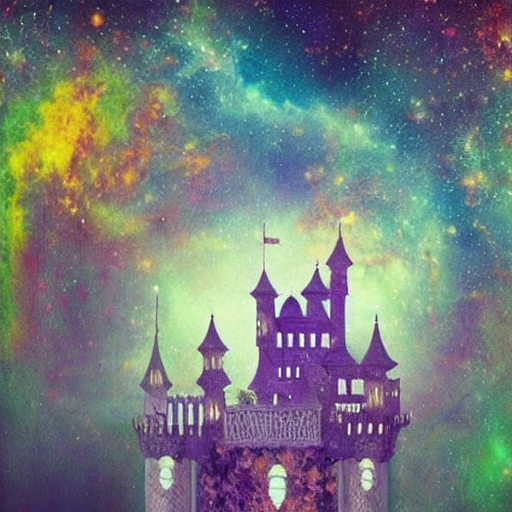

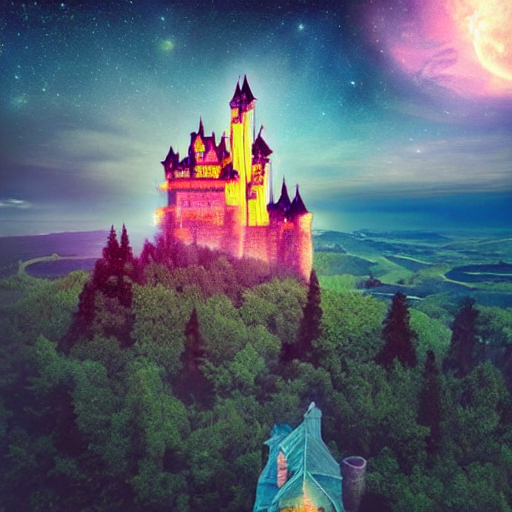

CPU times: user 407 ms, sys: 13.9 ms, total: 421 ms
Wall time: 47.3 s


In [26]:
%%time
import json
content_type = "application/json"
request_body = {"prompt": "a dream castle, overlooking the universe, ethereal colors.","num_inference_steps":75,"results":2}

#Serialize data for endpoint
data = json.loads(json.dumps(request_body))
payload = json.dumps(data)

#Endpoint invocation
response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType=content_type,
    Body=payload)

#Parse results
results = json.loads(response['Body'].read().decode())['s3_loc']
print (results)

for result in results:
    #display the image
    bucket = s3.Bucket(BUCKET_NAME)
    new_image = bucket.Object(FOLDER+result)
    img_data = new_image.get().get('Body').read()

    new_image = Image.open(io.BytesIO(img_data))

    display(new_image)

## 7. Clean up resources
Use this section to delete any of the resources we have deployed using this notebook.  Don't forget to shut off the instance running this notebook when you are done!  You may also want to head over to S3 and clear out your image bucket.

In [ ]:
sm_client = boto3.client(service_name='sagemaker')
sm_client.delete_model(ModelName=model_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_endpoint(EndpointName=endpoint_name)